In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# ---------------------------------------------------------
# Load spatial transcriptomics data
# ---------------------------------------------------------
adata = sc.read_h5ad("LC_091.h5ad")
print(adata)

# ---------------------------------------------------------
# Inspect available spatial libraries (Visium library IDs)
# ---------------------------------------------------------
print("Libraries in adata.uns['spatial']:", list(adata.uns['spatial'].keys()))

lib_id = "LC_091"

# Inspect keys stored under the selected library
print("Keys in adata.uns['spatial'][lib_id]:",
      adata.uns['spatial'][lib_id].keys())

# Inspect available image resolutions (e.g., 'hires', 'lowres')
print("Available image keys:",
      adata.uns['spatial'][lib_id]['images'].keys())

# ---------------------------------------------------------
# Visualize the H&E image
# ---------------------------------------------------------
# Retrieve the stored H&E image (typically 'hires' or 'lowres')
he_img = adata.uns['spatial'][lib_id]['images']['hires']   # high resolution


AnnData object with n_obs × n_vars = 2141 × 16261
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'annotation'
    uns: 'msi', 'mz_features', 'orig.ident_colors', 'seurat_clusters_colors', 'spatial'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'spatial'
    layers: 'log1p', 'raw'
Libraries in adata.uns['spatial']: ['LC_091', 'LC_091_Visium', 'LC_170', 'LC_276']
Keys in adata.uns['spatial'][lib_id]: dict_keys(['images', 'metadata', 'scalefactors'])
Available image keys: dict_keys(['hires', 'lowres'])


In [2]:
adata.obs['annotation'].unique()
adata.obs['annotation'].value_counts()


Normal cells    1307
Tumor            548
Airway           158
Unlabelled        72
Blood vessel      29
Lymphocytes       27
Name: annotation, dtype: int64

<ipython-input-3-0531090c4663>:57: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in getattr(leg, "legendHandles", []):


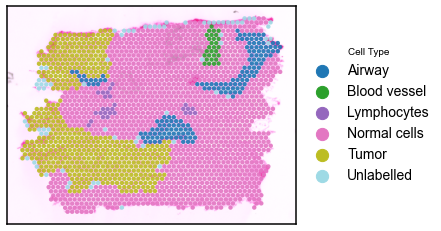

In [3]:
# ---------------------------------------------------------
# Global font settings
# ---------------------------------------------------------
rcParams["font.family"] = "Arial"
rcParams["font.size"] = 16
rcParams["axes.titlesize"] = 16
rcParams["axes.labelsize"] = 14
rcParams["legend.fontsize"] = 14

# ---------------------------------------------------------
# Color palette (truncate based on the number of categories)
# ---------------------------------------------------------
palette = sc.pl.palettes.default_20[:6]

library_id = "LC_091"

# ---------------------------------------------------------
# Plot spatial annotation and return Axes
# ---------------------------------------------------------
ax_or_axes = sc.pl.spatial(
    adata,
    library_id=library_id,
    img_key="hires",
    color="annotation",
    spot_size=20,
    alpha=0.9,
    palette="tab20",
    legend_loc="right margin",
    frameon=True,
    title="",          # Remove default title
    show=False         # Key: return Axes for further customization
)

# Handle single vs. multiple Axes
axes = ax_or_axes if isinstance(ax_or_axes, (list, tuple)) else [ax_or_axes]

# ---------------------------------------------------------
# Aesthetic adjustments
# ---------------------------------------------------------
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_color("black")

# ---------------------------------------------------------
# Customize legend (right margin)
# ---------------------------------------------------------
leg = axes[0].get_legend()
if leg is not None:
    leg.set_title("Cell Type")
    leg.get_title().set_fontsize("medium")
    for h in getattr(leg, "legendHandles", []):
        try:
            h.set_sizes([150])  # Effective for PathCollection
        except Exception:
            pass

# ---------------------------------------------------------
# Save figure as SVG
# ---------------------------------------------------------
out_path = f"{library_id}_annotation_spatial.svg"
axes[0].figure.savefig(
    out_path,
    format="svg",
    bbox_inches="tight"
)  # optional: transparent=True, dpi=300

# Close figure if display is not required
# plt.close(axes[0].figure)


In [4]:
import numpy as np
from PIL import Image
import os

def save_he_image(adata, library_id="LC_091", out_base=None, upscale=1):
    """
    Save the Visium H&E image at the highest available resolution.

    Parameters
    ----------
    adata : AnnData
        AnnData object containing spatial information.
    library_id : str
        Visium library ID.
    out_base : str or None
        Output filename prefix (without extension).
        Default: f"{library_id}_HE"
    upscale : int
        Upsampling factor (1 = no upsampling; 2/4 can improve visual clarity).
        Note: upsampling does not add new information.
    """
    if out_base is None:
        out_base = f"{library_id}_HE"

    # ---------------------------------------------------------
    # 1) Select the highest available image resolution
    # ---------------------------------------------------------
    img_dict = adata.uns["spatial"][library_id]["images"]
    pref = ["fullres", "hires", "lowres"]  # resolution priority
    for k in pref:
        if k in img_dict:
            img = img_dict[k]
            level = k
            break
    else:
        raise KeyError(
            f"No H&E image found in adata.uns['spatial']['{library_id}']['images']"
        )

    # ---------------------------------------------------------
    # 2) Normalize image to uint8
    # ---------------------------------------------------------
    arr = np.asarray(img)
    if arr.dtype != np.uint8:
        # Common cases: float in [0, 1] or numeric in [0, 255]
        if arr.max() <= 1.0:
            arr = (arr * 255.0).round().astype(np.uint8)
        else:
            arr = np.clip(arr, 0, 255).round().astype(np.uint8)

    pil_img = Image.fromarray(arr)

    # ---------------------------------------------------------
    # 3) Optional upsampling for improved visual clarity
    # ---------------------------------------------------------
    if upscale and upscale > 1:
        w, h = pil_img.size
        pil_img = pil_img.resize(
            (w * upscale, h * upscale),
            resample=Image.LANCZOS
        )

    # ---------------------------------------------------------
    # 4) Save PNG (lossless, highest quality)
    # ---------------------------------------------------------
    png_path = f"{out_base}_{level}.png"
    pil_img.save(
        png_path,
        format="PNG",
        compress_level=0  # minimal compression for best quality
    )

    # ---------------------------------------------------------
    # 5) Save SVG (embedded raster image)
    # ---------------------------------------------------------
    try:
        import matplotlib.pyplot as plt
        fig = plt.figure(
            figsize=(pil_img.width / 100, pil_img.height / 100),
            dpi=100
        )
        ax = plt.axes([0, 0, 1, 1])
        ax.axis("off")
        ax.imshow(pil_img)

        svg_path = f"{out_base}_{level}.svg"
        fig.savefig(
            svg_path,
            format="svg",
            bbox_inches="tight",
            pad_inches=0
        )
        plt.close(fig)
    except Exception as e:
        svg_path = None
        print("SVG export skipped:", e)

    print(f"Saved H&E PNG → {os.path.abspath(png_path)}")
    if svg_path:
        print(f"Saved H&E SVG → {os.path.abspath(svg_path)}")


# ---------------------------------------------------------
# Example usage
# ---------------------------------------------------------
# Save original resolution
save_he_image(
    adata,
    library_id="LC_091",
    out_base="LC_091_HE",
    upscale=1
)

# For higher visual clarity (e.g., posters or large figures), use 2× upsampling:
# save_he_image(adata, library_id="LC_091", out_base="LC_091_HE", upscale=2)


Saved H&E PNG → /Users/dubingxue/Desktop/SHINE clean code/SHINE code-Fig4/LC_091_HE_hires.png
Saved H&E SVG → /Users/dubingxue/Desktop/SHINE clean code/SHINE code-Fig4/LC_091_HE_hires.svg


In [5]:
adata.var_names_make_unique()

# Specify species ('human' or 'mouse')
species = 'human'  # Change this to 'human' if analyzing human data

# Identify mitochondrial genes based on species
mt_prefix = 'MT-' if species == 'human' else 'mt-'
adata.var['mt'] = adata.var_names.str.startswith(mt_prefix)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Additional QC filtering
adata = adata[adata.obs.pct_counts_mt <= 38, :]  # Remove spots with mitochondrial genes > 38%
adata = adata[adata.obs.n_genes_by_counts >= 50, :]  # Remove spots with fewer than 50 genes expressed

# Remove specific gene categories based on species
if species == 'human':
    genes_remove_prefixes = ('HB', 'Hb', 'RPS', 'RPL', 'MALAT1', 'Malat1')
else:
    genes_remove_prefixes = ('Hba', 'Hbb', 'Rps', 'Rpl', 'Malat1')

# Apply gene filtering
genes_remove = adata.var_names[adata.var_names.str.startswith(genes_remove_prefixes)]
adata = adata[:, ~adata.var_names.isin(genes_remove)]

# Normalize gene expression (total expression per spot to 10,000)
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)

# Log-transform
sc.pp.log1p(adata)

# Highly variable genes (Seurat method)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

# Keep only highly variable genes
gene_expression = adata.to_df()
high_variance_genes = adata.var[adata.var["highly_variable"]].index
gene_expression = gene_expression[high_variance_genes]

print(f"Selected {len(high_variance_genes)} highly variable genes for analysis.")
gene_expression


/Users/dubingxue/opt/anaconda3/envs/smt/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/dubingxue/opt/anaconda3/envs/smt/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Selected 2000 highly variable genes for analysis.


,ISG15,TTLL10,TNFRSF18,MXRA8,TMEM52,CFAP74,PLCH2,WRAP73,TP73,KCNAB2,...,GPC3,FHL1,LDOC1,CETN2,ZNF185,PNCK,ARHGAP4,RENBP,FLNA,MPP1
AACACTTGGCAAGGAA-1_1,0.718045,0.000000,0.718045,1.131673,0.000000,0.000000,0.000000,0.000000,0.718045,1.131673,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.832918,0.718045,0.000000,1.131673
AACAGGATTCATAGTT-1_1,0.000000,0.000000,0.000000,0.712652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.124535,0.000000
AACAGGTTATTGCACC-1_1,0.000000,0.824859,0.000000,2.002532,0.000000,0.824859,0.824859,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2.162098,0.000000
AACAGGTTCACCGAAG-1_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.705886,0.000000
AACATAGTCTATCTAC-1_1,0.000000,0.000000,0.000000,1.265771,0.000000,0.000000,0.000000,0.000000,0.000000,1.572512,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.265771,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTCTGCTCTGTCGT-1_1,0.000000,0.000000,1.125167,1.641220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.713129,0.000000,0.000000,0.0,0.000000,0.0,1.824845,0.000000,2.232477,0.000000
TGTTGCGTCCAAGATT-1_1,0.000000,0.687889,0.687889,0.687889,0.000000,0.000000,0.687889,0.687889,0.000000,0.687889,...,0.000000,0.000000,1.091595,0.0,0.000000,0.0,0.687889,0.687889,1.091595,1.091595
TGTTGGAACCTTCCGC-1_1,1.572613,0.000000,0.000000,1.807025,0.000000,0.000000,0.821133,0.000000,0.000000,0.821133,...,0.821133,0.000000,0.821133,0.0,0.000000,0.0,1.572613,0.000000,1.265862,0.000000
TGTTGGAACGAGGTCA-1_1,0.692847,0.000000,0.000000,1.791260,0.000000,0.000000,0.000000,0.000000,0.000000,1.098212,...,0.000000,0.692847,0.692847,0.0,0.000000,0.0,0.692847,0.000000,1.945396,0.000000


In [6]:
# ---------------------------------------------------------
# Check whether spatial information exists in adata.uns
# ---------------------------------------------------------
if "spatial" not in adata.uns:
    raise KeyError("The 'spatial' key is missing in adata.uns.")

# ---------------------------------------------------------
# Retrieve spatial information
# ---------------------------------------------------------
spatial_info = adata.uns["spatial"]

# Retrieve sample ID (typically only one sample is present)
sample_id = list(spatial_info.keys())[0]
print(f"Sample ID: {sample_id}")

# ---------------------------------------------------------
# Retrieve scale factor for high-resolution tissue image
# ---------------------------------------------------------
scale_factor = spatial_info[sample_id]["scalefactors"]["tissue_hires_scalef"]

# Retrieve high-resolution tissue image
tissue_hires_image = adata.uns["spatial"][sample_id]["images"]["hires"]

# Get image height and width
img_height, img_width = tissue_hires_image.shape[:2]

print(f"Scale factor: {scale_factor}")


Sample ID: LC_091
Scale factor: 0.6666667


In [7]:
# ---------------------------------------------------------
# Metabolomics matrix
# ---------------------------------------------------------
MSI = adata.uns["msi"]
print("MSI matrix shape:", MSI.shape)   # (spots × m/z_features)

# ---------------------------------------------------------
# List of m/z features
# ---------------------------------------------------------
mz_list = adata.uns["mz_features"]
print("Number of m/z features:", len(mz_list))
print("First 10 m/z features:", mz_list[:10])

mz_list


MSI matrix shape: (2141, 2086)
Number of m/z features: 2086
First 10 m/z features: ['255.23109612934098' '283.262461778844' '325.1826419711799'
 '311.1676841080394' '248.95872827128738' '339.1990497575424'
 '256.23444299891406' '112.98492851903' '297.15127632167696'
 '284.2658086484171']


array(['255.23109612934098', '283.262461778844', '325.1826419711799', ...,
       '683.5224667309571', '466.93583568603594', '413.29157632120314'],
      dtype=object)

In [8]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# Retrieve metabolomics matrix and m/z feature list
# ---------------------------------------------------------
MSI = adata.uns["msi"]          # shape: (n_spots × n_features)
mz_list = adata.uns["mz_features"]  # length: n_features

# ---------------------------------------------------------
# Retrieve spatial coordinates (typically stored in adata.obsm["spatial"])
# ---------------------------------------------------------
coords = pd.DataFrame(
    adata.obsm["spatial"],
    columns=["x", "y"]
)

# ---------------------------------------------------------
# Construct MSI DataFrame with m/z feature names
# ---------------------------------------------------------
msi_df = pd.DataFrame(
    MSI,
    columns=[f"mz_{mz}" for mz in mz_list]
)

# ---------------------------------------------------------
# Combine spatial coordinates and MSI matrix
# ---------------------------------------------------------
final_msi_df = pd.concat(
    [coords.reset_index(drop=True), msi_df.reset_index(drop=True)],
    axis=1
)

# ---------------------------------------------------------
# Compute Total Ion Current (TIC)
# ---------------------------------------------------------
final_msi_df["TIC"] = msi_df.sum(axis=1)

# Remove spots with zero TIC
final_msi_df = final_msi_df[
    final_msi_df["TIC"] > 0
].reset_index(drop=True)

# ---------------------------------------------------------
# TIC normalization (scale each spot to a fixed total count)
# ---------------------------------------------------------
target_total = 10000
msi_norm = msi_df.div(msi_df.sum(axis=1), axis=0) * target_total

# ---------------------------------------------------------
# Log1p transformation
# ---------------------------------------------------------
msi_log = np.log1p(msi_norm)

# Replace raw intensities with log-transformed values
final_msi_df.update(msi_log)

# ---------------------------------------------------------
# Inspect results
# ---------------------------------------------------------
print(final_msi_df.head())

msi_data = final_msi_df
msi_data


      x     y  mz_255.23109612934098  mz_283.262461778844  \
0  1039  1669               4.501958             3.883207   
1   738  1707               4.353744             3.999020   
2  1200  1314               4.347235             3.880859   
3   717  1744               4.486656             4.132904   
4   556  1875               4.617118             3.769865   

   mz_325.1826419711799  mz_311.1676841080394  mz_248.95872827128738  \
0              3.019372              2.958029               6.168648   
1              3.107966              2.982888               6.128829   
2              3.423304              3.320547               6.582479   
3              3.129611              2.935628               6.098904   
4              3.141900              3.046301               6.320748   

   mz_339.1990497575424  mz_256.23444299891406  mz_112.98492851903  ...  \
0              2.876033               2.887157            5.398294  ...   
1              2.971715               2.617211    

,x,y,mz_255.23109612934098,mz_283.262461778844,mz_325.1826419711799,mz_311.1676841080394,mz_248.95872827128738,mz_339.1990497575424,mz_256.23444299891406,mz_112.98492851903,...,mz_362.1397349748619,mz_697.4779777419988,mz_338.9279141150422,mz_846.6562282763398,mz_275.82290572713964,mz_438.19835742745477,mz_683.5224667309571,mz_466.93583568603594,mz_413.29157632120314,TIC
0,1039,1669,4.501958,3.883207,3.019372,2.958029,6.168648,2.876033,2.887157,5.398294,...,0.244733,0.929184,0.028284,0.097142,0.181934,0.164513,0.253570,0.163938,0.001370,4023.114778
1,738,1707,4.353744,3.999020,3.107966,2.982888,6.128829,2.971715,2.617211,5.405510,...,0.166299,1.225947,0.066170,0.547564,0.323735,0.185946,1.189381,0.543930,0.400128,3746.542656
2,1200,1314,4.347235,3.880859,3.423304,3.320547,6.582479,3.209974,2.586777,5.767188,...,0.002039,0.025686,0.453184,0.194667,0.310515,0.000000,0.054694,0.600672,0.007000,2950.353125
3,717,1744,4.486656,4.132904,3.129611,2.935628,6.098904,2.854751,2.780991,5.244609,...,0.000000,1.956647,0.163940,0.668904,0.484050,0.568368,0.218037,0.299074,0.022231,3616.667582
4,556,1875,4.617118,3.769865,3.141900,3.046301,6.320748,2.771645,2.835645,5.400147,...,0.000000,1.044629,0.000000,0.000000,0.127005,0.157064,0.528414,0.427199,0.000000,4074.344009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,695,1520,4.205699,3.907992,3.175679,3.295148,6.520367,2.983836,2.527514,5.712192,...,0.033489,0.730192,0.209966,1.332481,0.823152,0.000000,0.503324,0.574664,0.000000,3251.831701
2137,975,1744,4.442237,3.725338,2.889263,2.664974,5.936690,2.847025,2.785506,5.196821,...,0.000000,1.015433,0.033304,0.000000,0.321173,0.000000,0.131377,0.149857,0.029495,4435.173988
2138,652,1445,4.422280,3.986589,3.305472,3.180152,6.415501,2.954371,2.535798,5.734097,...,0.012320,0.496885,0.194991,0.212341,0.059787,0.329720,1.202368,0.119390,0.331000,2838.198503
2139,1050,1314,4.116458,4.015032,3.122130,2.900660,6.315971,2.911708,2.548791,5.529290,...,0.066707,0.930076,0.884986,0.032599,0.306262,0.787177,1.369644,0.064867,0.015192,3640.681464


In [9]:
rna_pixel_coords = adata.obsm["spatial"] * scale_factor  
rna_pixel_coords

array([[ 692.6667013, 1112.6667223],
       [ 492.0000246, 1138.0000569],
       [ 800.00004  ,  876.0000438],
       ...,
       [ 434.6666884,  963.3333815],
       [ 700.000035 ,  876.0000438],
       [ 520.6666927, 1138.0000569]])

In [10]:

rna_coords = pd.DataFrame(
    rna_pixel_coords,
    columns=['x', 'y'],
    index=adata.obs_names  # preserve spot names
)

# Convert index to a column named "spot"
rna_coords.reset_index(inplace=True)
rna_coords.rename(columns={'index': 'spot'}, inplace=True)

rna_expression_df = gene_expression.copy()
rna_expression_df.reset_index(drop=True, inplace=True)

rna_final_df = pd.concat(
    [
        rna_coords.reset_index(drop=True),
        rna_expression_df.reset_index(drop=True)
    ],
    axis=1
)

rna_final_df.to_csv("aligned_ST_data.csv", index=False)

print("Saved aligned RNA spatial transcriptomics data:")
print(rna_final_df.head())


metabolite_names = msi_data.columns[2:-5]  # exclude coordinates, TIC, and alignment columns

# Extract interpolated metabolite values
aggregated_metabolites = msi_data.iloc[:, 2:-5].values

# Create metabolite DataFrame
aggregated_metabolites_df = pd.DataFrame(
    aggregated_metabolites,
    columns=metabolite_names
)

# Merge with RNA spatial coordinates
aggregated_metabolites_df = pd.concat(
    [
        rna_coords.reset_index(drop=True),
        aggregated_metabolites_df
    ],
    axis=1
)

# Save aligned spatial metabolomics data
aggregated_metabolites_df.to_csv("aligned_SM_data.csv", index=False)


Saved aligned RNA spatial transcriptomics data:
                   spot           x            y     ISG15    TTLL10  \
0  AACACTTGGCAAGGAA-1_1  692.666701  1112.666722  0.718045  0.000000   
1  AACAGGATTCATAGTT-1_1  492.000025  1138.000057  0.000000  0.000000   
2  AACAGGTTATTGCACC-1_1  800.000040   876.000044  0.000000  0.824859   
3  AACAGGTTCACCGAAG-1_1  478.000024  1162.666725  0.000000  0.000000   
4  AACATAGTCTATCTAC-1_1  370.666685  1250.000062  0.000000  0.000000   

   TNFRSF18     MXRA8  TMEM52    CFAP74     PLCH2  ...  GPC3  FHL1  LDOC1  \
0  0.718045  1.131673     0.0  0.000000  0.000000  ...   0.0   0.0    0.0   
1  0.000000  0.712652     0.0  0.000000  0.000000  ...   0.0   0.0    0.0   
2  0.000000  2.002532     0.0  0.824859  0.824859  ...   0.0   0.0    0.0   
3  0.000000  0.000000     0.0  0.000000  0.000000  ...   0.0   0.0    0.0   
4  0.000000  1.265771     0.0  0.000000  0.000000  ...   0.0   0.0    0.0   

   CETN2  ZNF185  PNCK   ARHGAP4     RENBP      FLNA    

In [11]:
from torch_geometric.data import Data
from scipy.spatial import distance_matrix
import torch
import numpy as np

# === Transcriptomics Data ===
transcript_data = Data(
    x=torch.tensor(gene_expression.values, dtype=torch.float),
    pos=torch.tensor(rna_pixel_coords, dtype=torch.float)
)

# === Metabolomics Data ===
metabolite_data = Data(
    x=torch.tensor(aggregated_metabolites, dtype=torch.float),
    pos=torch.tensor(rna_pixel_coords, dtype=torch.float)
)

# === Transcript-to-transcript edges ===
dist_matrix_tt = distance_matrix(rna_pixel_coords, rna_pixel_coords)
print(f"Transcript distance matrix stats: min={dist_matrix_tt.min()}, max={dist_matrix_tt.max()}, mean={dist_matrix_tt.mean()}")
dynamic_threshold_tt = np.percentile(dist_matrix_tt, 5)
print(f"Dynamic transcript threshold: {dynamic_threshold_tt}")

edges_tt = np.transpose(np.where((dist_matrix_tt < dynamic_threshold_tt) & (dist_matrix_tt > 0)))

if edges_tt.size > 0:
    adj_tt_tensor = torch.tensor(edges_tt, dtype=torch.long).t().contiguous()
    adj_tt_matrix = torch.zeros((len(rna_pixel_coords), len(rna_pixel_coords)))
    adj_tt_matrix[adj_tt_tensor[0], adj_tt_tensor[1]] = 1
    transcript_data.edge_index = adj_tt_tensor
    print(f"Generated {edges_tt.shape[0]} transcript-to-transcript edges.")
else:
    print("Warning: No transcript-to-transcript edges generated.")
    adj_tt_matrix = torch.zeros((len(rna_pixel_coords), len(rna_pixel_coords)))
    transcript_data.edge_index = torch.empty((2, 0), dtype=torch.long)

# === Metabolite-to-metabolite edges ===
dist_matrix_mm = distance_matrix(rna_pixel_coords, rna_pixel_coords)  
print(f"Metabolite distance matrix stats: min={dist_matrix_mm.min()}, max={dist_matrix_mm.max()}, mean={dist_matrix_mm.mean()}")
dynamic_threshold_mm = np.percentile(dist_matrix_mm, 5)  
print(f"Dynamic metabolite threshold: {dynamic_threshold_mm}")

num_spots = aggregated_metabolites.shape[0]

edges_mm = np.transpose(np.where(
    (dist_matrix_mm < dynamic_threshold_mm) & (dist_matrix_mm > 0)
))

if edges_mm.size > 0:
    adj_mm_tensor = torch.tensor(edges_mm, dtype=torch.long).t().contiguous()
    adj_mm_matrix = torch.zeros((num_spots, num_spots))
    adj_mm_matrix[adj_mm_tensor[0], adj_mm_tensor[1]] = 1
    metabolite_data.edge_index = adj_mm_tensor
    print(f"Generated {edges_mm.shape[0]} metabolite-to-metabolite edges.")
else:
    print("Warning: No metabolite-to-metabolite edges generated.")
    adj_mm_matrix = torch.zeros((num_spots, num_spots))
    metabolite_data.edge_index = torch.empty((2, 0), dtype=torch.long)

RDKit WARNING: [13:02:24] Enabling RDKit 2019.09.3 jupyter extensions


Transcript distance matrix stats: min=0.0, max=857.4660771860317, mean=326.6725368329148
Dynamic transcript threshold: 85.99742028172194
Generated 226766 transcript-to-transcript edges.
Metabolite distance matrix stats: min=0.0, max=857.4660771860317, mean=326.6725368329148
Dynamic metabolite threshold: 85.99742028172194
Generated 226766 metabolite-to-metabolite edges.


In [12]:
from torch_geometric.utils import add_self_loops

transcript_data.pos = torch.tensor(rna_pixel_coords, dtype=torch.float)
transcript_data.edge_index = adj_tt_matrix.nonzero(as_tuple=False).t()

metabolite_data.pos = torch.tensor(rna_pixel_coords, dtype=torch.float)
metabolite_data.edge_index = adj_mm_matrix.nonzero(as_tuple=False).t()

transcript_data.edge_index, _ = add_self_loops(
    transcript_data.edge_index, 
    num_nodes=transcript_data.x.size(0)
)
metabolite_data.edge_index, _ = add_self_loops(
    metabolite_data.edge_index, 
    num_nodes=metabolite_data.x.size(0)
)

print("Self-loops added successfully.")

# Save processed data 
torch.save({
    "transcript_data": transcript_data,
    "metabolite_data": metabolite_data,
}, "graph_data.pt")

print("Updated graph data and matched full information saved successfully.")

Self-loops added successfully.
Updated graph data and matched full information saved successfully.
